In [1]:
import sys
sys.path.append('GAN')
from GAN.utils import *
from GAN.ops import *

import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import math
from glob import glob
from tensorflow.contrib import learn
import numpy as np
from tqdm import tqdm

In [2]:
class WGAN_GP(object):

  def __init__(self,
               sess,
               input_height=28,
               input_width=28,
               crop=True,
               batch_size=64,
               output_height=28,
               output_width=28,
               y_dim=None,
               z_dim=100,
               gf_dim=64,
               df_dim=64,
               gfc_dim=1024,
               dfc_dim=1024,
               c_dim=1,
               dataset_name='mnist',
               input_fname_pattern='*.jpg',
               checkpoint_dir='checkpoint',
               samples_dir=None,
               show_samples=False,
               learning_rate=2e-4,
               beta1=0.5,
               epoch=100):
    """
    Args:
      sess: TensorFlow session
      batch_size: The size of batch. Should be specified before training.
      y_dim: (optional) Dimension of dim for y. [None]
      z_dim: (optional) Dimension of dim for Z. [100]
      gf_dim: (optional) Dimension of gen filters in first conv layer. [64]
      df_dim: (optional) Dimension of discrim filters in first conv layer. [64]
      gfc_dim: (optional) Dimension of gen units for for fully connected layer. [1024]
      dfc_dim: (optional) Dimension of discrim units for fully connected layer. [1024]
      c_dim: (optional) Dimension of image color. For grayscale input, set to 1. [3]
        """
    self.sess = sess

    self.epoch = epoch
    self.batch_size = batch_size
    self.sample_num = 200
    self.learning_rate = learning_rate
    self.beta1 = beta1

    self.input_height = input_height
    self.input_width = input_width
    self.output_height = output_height
    self.output_width = output_width

    self.y_dim = y_dim
    self.z_dim = z_dim

    self.gf_dim = gf_dim
    self.df_dim = df_dim

    self.gfc_dim = gfc_dim
    self.dfc_dim = dfc_dim

    self.input_fname_pattern = input_fname_pattern
    self.dataset_name = dataset_name
    self.checkpoint_dir = checkpoint_dir
    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    self.samples_dir = samples_dir
    if not os.path.exists(samples_dir) and samples_dir is not None:
      os.makedirs(samples_dir)
    self.show_samples = show_samples

    self.trX, self.teX = self.load_mnist()
    self.ntrain = len(self.trX)
    self.c_dim = 1
    self.grayscale = (self.c_dim == 1)
    self.log = {'d_loss': [], 'g_loss': [], 'gen_samples': []}
    self.build_model()

  def build_model(self):

    # Training critic 5 iterations per generator iteration
    self.n_critic = 5

    image_dims = [self.input_height, self.input_width, self.c_dim]

    self.inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='real_images')
    self.sample_inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='sample_inputs')

    inputs = self.inputs
    sample_inputs = self.sample_inputs

    self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')

    self.G = self.generator(self.z)
    
    self.D, self.D_logits_real = self.discriminator(inputs)
    self.D_, self.D_logits_fake = self.discriminator(self.G, reuse=True)

    self.d_loss_real = tf.reduce_mean(self.D_logits_real)
    self.d_loss_fake = tf.reduce_mean(self.D_logits_fake)
    self.g_loss = -tf.reduce_mean(self.D_logits_fake)
    self.d_loss = self.d_loss_fake - self.d_loss_real

    t_vars = tf.trainable_variables()

    self.d_vars = [var for var in t_vars if 'd_' in var.name]
    self.g_vars = [var for var in t_vars if 'g_' in var.name]
    self.saver = tf.train.Saver()

  def train(self):
    
    # modified
    
    alpha = tf.random_uniform(
        shape=[self.batch_size, 1], 
        minval=0.,
        maxval=1.
    )
    
    real_data = tf.reshape(self.inputs, [-1, 28 * 28])
    fake_data = tf.reshape(self.G, [-1, 28 * 28])
    
    differences = fake_data - real_data
    interpolates = real_data + (alpha * differences)
    
    reshape_interpolates = tf.reshape(interpolates, (-1, 28, 28, 1))
    
    print(reshape_interpolates.shape)
    gradients = tf.gradients(self.discriminator(reshape_interpolates, reuse=True), [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    gradient_penalty = tf.reduce_mean((slopes-1.)**2)
    
    LAMBDA = 10 # Gradient penalty lambda hyperparameter
    self.d_loss += LAMBDA * gradient_penalty
    
    g_optim = tf.train.AdamOptimizer(
        learning_rate=1e-4, 
        beta1=0.5,
        beta2=0.9
    ).minimize(self.g_loss, var_list=self.g_vars)
    
    d_optim = tf.train.AdamOptimizer(
        learning_rate=1e-4, 
        beta1=0.5, 
        beta2=0.9
    ).minimize(self.d_loss, var_list=self.d_vars)
    
    '''
    g_optim = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(
        self.g_loss, var_list=self.g_vars)
    d_optim = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(
        self.d_loss, var_list=self.d_vars)

    #get the weight clipping ops
    clip_ops = []
    for var in self.d_vars:
      clip_bounds = [-.01, .01]
      clip_ops.append(
          tf.assign(var, tf.clip_by_value(var, clip_bounds[0], clip_bounds[1])))
    clip_disc_weights = tf.group(*clip_ops)
    '''

    init = tf.global_variables_initializer()
    self.sess.run(init)

    sample_z = np.random.uniform(-1, 1, size=(self.sample_num, self.z_dim))
    sample_idxs = np.random.randint(
        low=0, high=len(self.trX), size=self.sample_num)
    sample_inputs = self.trX[sample_idxs]

    counter = 1
    self.n_critic += 1
    start_time = time.time()
    for epoch in range(self.epoch):
      shuffle(self.trX)
      for batch_images in iter_data(self.trX, size=self.batch_size):
        batch_z = np.random.uniform(-1, 1, [self.batch_size,
                                            self.z_dim]).astype(np.float32)
        if counter % self.n_critic:
          # Update D network
          self.sess.run(
              d_optim, feed_dict={
                  self.inputs: batch_images,
                  self.z: batch_z,
              })
          #Apply weight clipping to D network
          # modified
          #self.sess.run(clip_disc_weights)
        else:
          # Update G network
          self.sess.run(
              g_optim, feed_dict={
                  self.z: batch_z,
              })
        counter += 1

      errD_fake = self.d_loss_fake.eval(
          session=self.sess, feed_dict={self.z: batch_z})
      errD_real = self.d_loss_real.eval(
          session=self.sess, feed_dict={self.inputs: batch_images})
      errG = self.g_loss.eval(session=self.sess, feed_dict={self.z: batch_z})
      self.log['d_loss'].append(errD_fake + errD_real)
      self.log['g_loss'].append(errG)
      print("Epoch: [%2d] time: %.2fs, d_loss: %.4f, g_loss: %.4f" \
        % (epoch,time.time() - start_time, errD_fake+errD_real, errG))

      if (epoch + 1) % 1 == 0:
        samples = self.sess.run(
            self.G, feed_dict={
                self.z: sample_z,
            })
        img = grayscale_grid_vis(
            samples,
            nhw=(10, 20),
            save_path=self.samples_dir + '/%d.jpg' % epoch)
        self.log['gen_samples'].append(img)
        if (epoch + 1) % 10 == 0:
          if self.show_samples:
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

      if (epoch + 1) % 10 == 0:
        self.save(self.checkpoint_dir, counter)

  def discriminator(self, image, y=None, reuse=False):
    with tf.variable_scope("discriminator") as scope:
      if reuse:
        scope.reuse_variables()

      x = image
     
      # modified: remove all bn(batch normalization)  
      h0 = lrelu(conv2d(x, self.c_dim, name='d_h0_conv'))
      h1 = lrelu(conv2d(h0, self.df_dim, name='d_h1_conv'))
      h1 = flatten(h1)
      h2 = lrelu(linear(h1, self.dfc_dim, 'd_h2_lin'))
      h3 = linear(h2, 1, 'd_h3_lin')
    
      return tf.nn.sigmoid(h3), h3

  def generator(self, z, y=None):
    with tf.variable_scope("generator") as scope:
      s_h, s_w = self.output_height, self.output_width
      s_h2, s_h4 = int(s_h / 2), int(s_h / 4)
      s_w2, s_w4 = int(s_w / 2), int(s_w / 4)

      h0 = tf.nn.relu(linear(z, self.gfc_dim, 'g_h0_lin'))

      h1 = tf.nn.relu(linear(h0, self.gf_dim * 2 * s_h4 * s_w4, 'g_h1_lin'))
      h1 = tf.reshape(h1, [-1, s_h4, s_w4, self.gf_dim * 2])

      h2 = tf.nn.relu(deconv2d(h1, nf=self.gf_dim * 2, name='g_h2'))
      output = tf.nn.sigmoid(deconv2d(h2, nf=self.c_dim, name='g_h3'))
      return output

  def load_mnist(self):
    mnist = learn.datasets.load_dataset("mnist")
    train_data = mnist.train.images.reshape(-1, 28, 28, 1)  # Returns np.array
    test_data = mnist.test.images.reshape(-1, 28, 28, 1)  # Returns np.array
    return train_data, test_data

  @property
  def model_dir(self):
    return "%s_%s" % (self.dataset_name, self.batch_size)

  def save(self, checkpoint_dir, step):
    model_name = "DCGAN.model"
    checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    self.saver.save(
        self.sess, os.path.join(checkpoint_dir, model_name), global_step=step)

  def load(self, checkpoint_dir):
    import re
    print(" [*] Reading checkpoints...")
    checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
      ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
      self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
      counter = int(next(re.finditer("(\d+)(?!.*\d)", ckpt_name)).group(0))
      print(" [*] Success to read {}".format(ckpt_name))
      return True, counter
    else:
      print(" [*] Failed to find a checkpoint")
      return False, 0

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


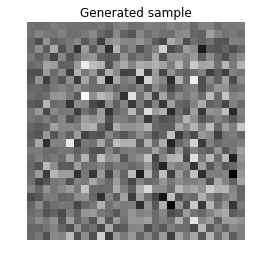

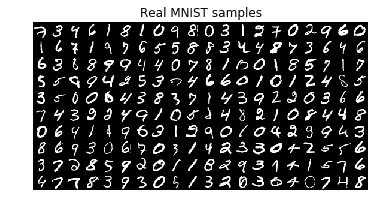

(16, 28, 28, 1)
Epoch: [ 0] time: 20.25s, d_loss: 3.5608, g_loss: 0.3206
Epoch: [ 1] time: 41.01s, d_loss: 5.9945, g_loss: -0.7399
Epoch: [ 2] time: 62.10s, d_loss: 4.7137, g_loss: -1.1976
Epoch: [ 3] time: 82.95s, d_loss: 3.0236, g_loss: -1.0574
Epoch: [ 4] time: 104.05s, d_loss: -4.3664, g_loss: 2.7721
Epoch: [ 5] time: 125.02s, d_loss: -4.6521, g_loss: 3.1827
Epoch: [ 6] time: 145.65s, d_loss: 6.5603, g_loss: -2.7265
Epoch: [ 7] time: 166.92s, d_loss: 7.1942, g_loss: -2.5995
Epoch: [ 8] time: 187.81s, d_loss: 7.0110, g_loss: -2.5419
Epoch: [ 9] time: 208.73s, d_loss: 8.1909, g_loss: -3.7520


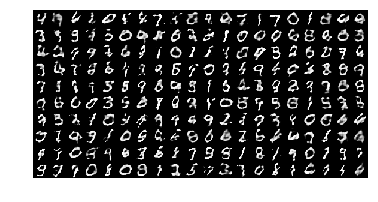

Epoch: [10] time: 231.22s, d_loss: 8.6761, g_loss: -3.8772
Epoch: [11] time: 252.28s, d_loss: -5.3960, g_loss: 2.7419
Epoch: [12] time: 273.47s, d_loss: 4.3819, g_loss: -1.8738
Epoch: [13] time: 294.58s, d_loss: 2.6428, g_loss: -0.8032
Epoch: [14] time: 315.44s, d_loss: -0.2970, g_loss: 0.5954
Epoch: [15] time: 336.24s, d_loss: -0.7192, g_loss: 0.4876
Epoch: [16] time: 356.95s, d_loss: -2.0704, g_loss: 1.1233
Epoch: [17] time: 378.37s, d_loss: -5.2491, g_loss: 2.8300
Epoch: [18] time: 399.21s, d_loss: 2.0112, g_loss: -0.7901
Epoch: [19] time: 419.77s, d_loss: -4.6179, g_loss: 2.1460


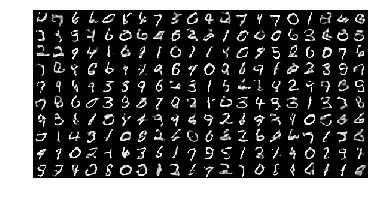

Epoch: [20] time: 441.56s, d_loss: 6.5022, g_loss: -3.0102
Epoch: [21] time: 461.89s, d_loss: 8.7626, g_loss: -4.2978
Epoch: [22] time: 482.78s, d_loss: 0.1055, g_loss: 0.2264
Epoch: [23] time: 503.62s, d_loss: -3.4698, g_loss: 1.8577
Epoch: [24] time: 524.34s, d_loss: 0.4120, g_loss: 0.3221
Epoch: [25] time: 544.85s, d_loss: 6.7795, g_loss: -3.6061
Epoch: [26] time: 565.97s, d_loss: 7.0879, g_loss: -3.5378
Epoch: [27] time: 586.57s, d_loss: 5.9598, g_loss: -2.4553
Epoch: [28] time: 607.57s, d_loss: -6.2807, g_loss: 3.0681
Epoch: [29] time: 628.69s, d_loss: -5.4991, g_loss: 2.4647


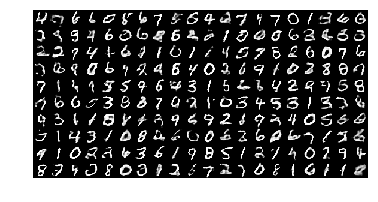

Epoch: [30] time: 651.10s, d_loss: -6.6478, g_loss: 3.3609
Epoch: [31] time: 672.09s, d_loss: 2.6032, g_loss: -1.0500
Epoch: [32] time: 693.12s, d_loss: -5.9608, g_loss: 3.1478
Epoch: [33] time: 714.09s, d_loss: -3.4669, g_loss: 1.7079
Epoch: [34] time: 734.81s, d_loss: 6.0349, g_loss: -2.8646
Epoch: [35] time: 755.90s, d_loss: 1.0623, g_loss: -0.2231
Epoch: [36] time: 777.04s, d_loss: -7.7298, g_loss: 3.9677
Epoch: [37] time: 798.01s, d_loss: -3.6364, g_loss: 1.9820
Epoch: [38] time: 819.13s, d_loss: 3.9824, g_loss: -1.5551
Epoch: [39] time: 840.15s, d_loss: 6.8831, g_loss: -3.0634


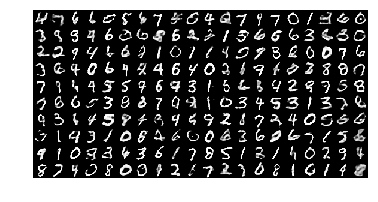

Epoch: [40] time: 862.63s, d_loss: 0.3280, g_loss: -0.0196
Epoch: [41] time: 883.41s, d_loss: 5.7616, g_loss: -2.9726
Epoch: [42] time: 904.28s, d_loss: -2.1573, g_loss: 1.0008
Epoch: [43] time: 925.29s, d_loss: 1.0387, g_loss: -0.2359
Epoch: [44] time: 946.29s, d_loss: -0.5130, g_loss: 0.5654
Epoch: [45] time: 967.19s, d_loss: -2.4493, g_loss: 1.4670
Epoch: [46] time: 988.18s, d_loss: 7.4639, g_loss: -3.4327
Epoch: [47] time: 1009.09s, d_loss: 6.3348, g_loss: -2.7968
Epoch: [48] time: 1030.15s, d_loss: 3.6815, g_loss: -1.6223
Epoch: [49] time: 1051.13s, d_loss: -4.1677, g_loss: 1.9431


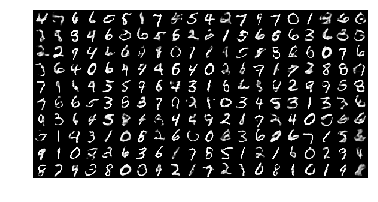

Epoch: [50] time: 1073.16s, d_loss: 7.8560, g_loss: -3.8121
Epoch: [51] time: 1094.39s, d_loss: -1.4544, g_loss: 0.7562
Epoch: [52] time: 1115.46s, d_loss: -2.8079, g_loss: 1.4727
Epoch: [53] time: 1136.69s, d_loss: 4.1615, g_loss: -2.3693
Epoch: [54] time: 1158.06s, d_loss: -2.9721, g_loss: 1.7346
Epoch: [55] time: 1179.28s, d_loss: 5.5990, g_loss: -2.9269
Epoch: [56] time: 1200.56s, d_loss: -3.5042, g_loss: 1.9202
Epoch: [57] time: 1221.39s, d_loss: 1.4907, g_loss: -0.5985
Epoch: [58] time: 1242.31s, d_loss: 3.5937, g_loss: -1.7976
Epoch: [59] time: 1263.22s, d_loss: 5.2513, g_loss: -2.3067


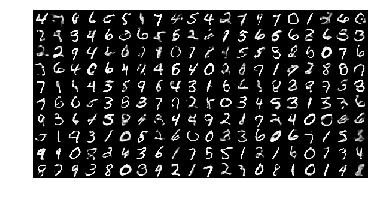

Epoch: [60] time: 1285.36s, d_loss: 5.1553, g_loss: -2.8446
Epoch: [61] time: 1306.31s, d_loss: 1.6937, g_loss: -0.5935
Epoch: [62] time: 1327.47s, d_loss: -5.0368, g_loss: 2.9993
Epoch: [63] time: 1348.69s, d_loss: -1.6369, g_loss: 0.8880
Epoch: [64] time: 1369.46s, d_loss: 8.1331, g_loss: -4.1567
Epoch: [65] time: 1390.38s, d_loss: -6.2114, g_loss: 3.0606
Epoch: [66] time: 1411.44s, d_loss: 2.4573, g_loss: -1.0939
Epoch: [67] time: 1432.19s, d_loss: 6.1430, g_loss: -2.8229
Epoch: [68] time: 1453.04s, d_loss: 7.0046, g_loss: -3.0680
Epoch: [69] time: 1474.00s, d_loss: 6.5527, g_loss: -2.7631


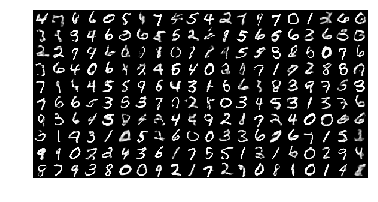

Epoch: [70] time: 1496.06s, d_loss: -1.9917, g_loss: 1.2318
Epoch: [71] time: 1516.64s, d_loss: 6.8285, g_loss: -3.6592
Epoch: [72] time: 1537.57s, d_loss: -6.4710, g_loss: 3.0747
Epoch: [73] time: 1558.67s, d_loss: -1.3955, g_loss: 0.5577
Epoch: [74] time: 1579.55s, d_loss: -5.1221, g_loss: 2.3568
Epoch: [75] time: 1600.52s, d_loss: -1.2329, g_loss: 0.9465
Epoch: [76] time: 1621.73s, d_loss: -3.8137, g_loss: 2.1268
Epoch: [77] time: 1642.68s, d_loss: -5.4368, g_loss: 2.9087
Epoch: [78] time: 1663.43s, d_loss: -5.0157, g_loss: 2.2073
Epoch: [79] time: 1684.19s, d_loss: -5.7758, g_loss: 3.1736


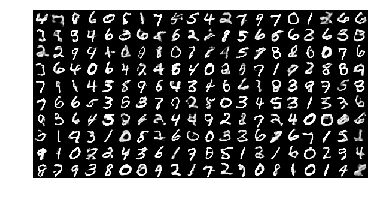

Epoch: [80] time: 1706.56s, d_loss: 6.0698, g_loss: -2.7761
Epoch: [81] time: 1727.46s, d_loss: 6.5202, g_loss: -3.4993
Epoch: [82] time: 1748.66s, d_loss: 7.0003, g_loss: -3.9347
Epoch: [83] time: 1769.84s, d_loss: -2.2648, g_loss: 1.2601
Epoch: [84] time: 1791.02s, d_loss: 2.2854, g_loss: -1.2609
Epoch: [85] time: 1812.08s, d_loss: 6.9523, g_loss: -3.5307
Epoch: [86] time: 1833.11s, d_loss: 8.9247, g_loss: -4.0457
Epoch: [87] time: 1854.16s, d_loss: -4.2215, g_loss: 2.0320
Epoch: [88] time: 1875.38s, d_loss: 2.8657, g_loss: -1.1713
Epoch: [89] time: 1896.01s, d_loss: 2.7618, g_loss: -1.0983


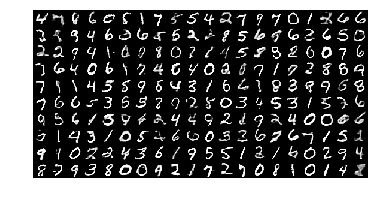

Epoch: [90] time: 1918.69s, d_loss: 7.3049, g_loss: -3.2284
Epoch: [91] time: 1939.73s, d_loss: -6.8559, g_loss: 3.6952
Epoch: [92] time: 1960.58s, d_loss: 3.7572, g_loss: -1.8738
Epoch: [93] time: 1981.57s, d_loss: -7.1293, g_loss: 3.5069
Epoch: [94] time: 2002.59s, d_loss: 7.7408, g_loss: -3.3137
Epoch: [95] time: 2023.21s, d_loss: -3.4568, g_loss: 1.5118
Epoch: [96] time: 2044.16s, d_loss: -7.2197, g_loss: 3.4580
Epoch: [97] time: 2065.02s, d_loss: 8.3572, g_loss: -3.8536
Epoch: [98] time: 2086.09s, d_loss: -7.3922, g_loss: 3.4572
Epoch: [99] time: 2107.37s, d_loss: -1.8389, g_loss: 1.0693


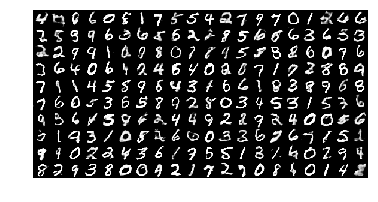

Epoch: [100] time: 2129.52s, d_loss: 7.4220, g_loss: -3.2730
Epoch: [101] time: 2150.57s, d_loss: -3.4242, g_loss: 1.6571
Epoch: [102] time: 2171.94s, d_loss: -2.8631, g_loss: 1.4224
Epoch: [103] time: 2192.45s, d_loss: -3.0272, g_loss: 1.7982
Epoch: [104] time: 2213.48s, d_loss: -7.8002, g_loss: 4.2935
Epoch: [105] time: 2234.71s, d_loss: 8.9963, g_loss: -4.8965
Epoch: [106] time: 2255.82s, d_loss: -8.7656, g_loss: 4.0471
Epoch: [107] time: 2276.80s, d_loss: -5.7564, g_loss: 2.7877
Epoch: [108] time: 2297.97s, d_loss: -1.7840, g_loss: 0.9889
Epoch: [109] time: 2319.12s, d_loss: -7.2928, g_loss: 3.9553


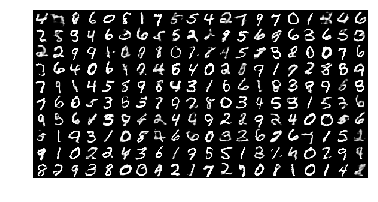

Epoch: [110] time: 2341.25s, d_loss: 7.6429, g_loss: -3.9502
Epoch: [111] time: 2362.32s, d_loss: 3.2996, g_loss: -1.4994
Epoch: [112] time: 2383.38s, d_loss: -3.8703, g_loss: 2.0375
Epoch: [113] time: 2404.39s, d_loss: 8.4389, g_loss: -4.5838
Epoch: [114] time: 2425.46s, d_loss: -5.7954, g_loss: 3.2201
Epoch: [115] time: 2446.41s, d_loss: -5.7426, g_loss: 3.3119
Epoch: [116] time: 2467.74s, d_loss: 6.1530, g_loss: -3.1867
Epoch: [117] time: 2488.86s, d_loss: -4.7946, g_loss: 2.5220
Epoch: [118] time: 2509.33s, d_loss: -1.6706, g_loss: 1.0035
Epoch: [119] time: 2529.96s, d_loss: 0.3935, g_loss: 0.0273


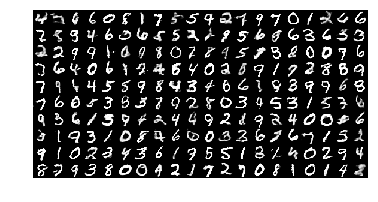

Epoch: [120] time: 2551.80s, d_loss: 5.4770, g_loss: -2.7275
Epoch: [121] time: 2572.61s, d_loss: 7.3727, g_loss: -3.7042
Epoch: [122] time: 2593.50s, d_loss: 3.0197, g_loss: -1.4746
Epoch: [123] time: 2614.41s, d_loss: -7.3727, g_loss: 3.8855
Epoch: [124] time: 2634.76s, d_loss: -6.9983, g_loss: 3.5646
Epoch: [125] time: 2655.75s, d_loss: 2.0084, g_loss: -0.9918
Epoch: [126] time: 2676.69s, d_loss: 3.5048, g_loss: -1.5239
Epoch: [127] time: 2697.59s, d_loss: -2.9490, g_loss: 1.7372
Epoch: [128] time: 2718.24s, d_loss: -6.1339, g_loss: 2.9134
Epoch: [129] time: 2738.44s, d_loss: -5.4913, g_loss: 2.6598


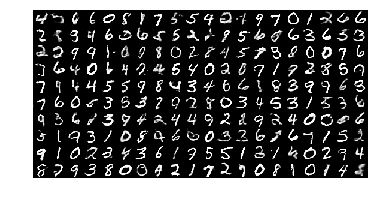

Epoch: [130] time: 2760.46s, d_loss: -2.9437, g_loss: 1.3862
Epoch: [131] time: 2781.28s, d_loss: -5.8671, g_loss: 3.0079
Epoch: [132] time: 2802.28s, d_loss: 4.8560, g_loss: -2.7268
Epoch: [133] time: 2822.76s, d_loss: 9.4629, g_loss: -4.2178
Epoch: [134] time: 2843.60s, d_loss: -8.6924, g_loss: 4.2692
Epoch: [135] time: 2864.82s, d_loss: -5.0976, g_loss: 2.5178
Epoch: [136] time: 2886.04s, d_loss: -3.1131, g_loss: 1.6719
Epoch: [137] time: 2907.04s, d_loss: -6.7197, g_loss: 3.5762
Epoch: [138] time: 2927.49s, d_loss: -7.2765, g_loss: 3.6015
Epoch: [139] time: 2947.69s, d_loss: -2.0205, g_loss: 1.1941


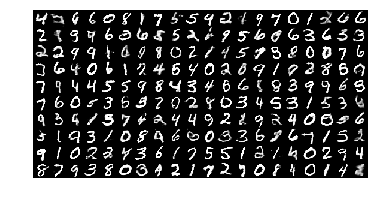

Epoch: [140] time: 2969.65s, d_loss: 1.2498, g_loss: -0.6993
Epoch: [141] time: 2990.57s, d_loss: -2.7828, g_loss: 1.5205
Epoch: [142] time: 3011.62s, d_loss: -1.7219, g_loss: 0.9705
Epoch: [143] time: 3032.50s, d_loss: -7.5572, g_loss: 3.2757
Epoch: [144] time: 3053.57s, d_loss: 3.0569, g_loss: -1.5271
Epoch: [145] time: 3074.50s, d_loss: -0.8827, g_loss: 0.5162
Epoch: [146] time: 3094.95s, d_loss: 4.4775, g_loss: -1.8076
Epoch: [147] time: 3115.79s, d_loss: -5.5871, g_loss: 3.0510
Epoch: [148] time: 3136.63s, d_loss: 8.8462, g_loss: -4.4662
Epoch: [149] time: 3157.36s, d_loss: 4.8705, g_loss: -2.4461


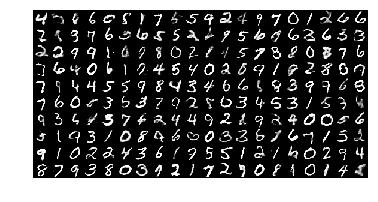

Epoch: [150] time: 3179.53s, d_loss: -6.6378, g_loss: 3.3674
Epoch: [151] time: 3200.32s, d_loss: 0.4136, g_loss: -0.1850
Epoch: [152] time: 3221.13s, d_loss: -5.7068, g_loss: 2.6503
Epoch: [153] time: 3241.85s, d_loss: 7.9058, g_loss: -4.2393
Epoch: [154] time: 3262.82s, d_loss: 4.8235, g_loss: -2.4914
Epoch: [155] time: 3283.53s, d_loss: 8.6418, g_loss: -4.5620
Epoch: [156] time: 3304.23s, d_loss: -1.2771, g_loss: 0.6244
Epoch: [157] time: 3324.97s, d_loss: -5.3922, g_loss: 2.8016
Epoch: [158] time: 3346.25s, d_loss: 4.6430, g_loss: -2.3906
Epoch: [159] time: 3367.25s, d_loss: -6.7712, g_loss: 3.3145


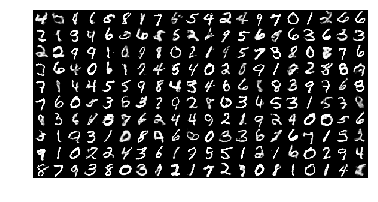

Epoch: [160] time: 3389.02s, d_loss: -9.7175, g_loss: 5.2760
Epoch: [161] time: 3409.60s, d_loss: 7.6089, g_loss: -3.6451
Epoch: [162] time: 3430.29s, d_loss: -5.9725, g_loss: 2.6813
Epoch: [163] time: 3451.21s, d_loss: 0.0385, g_loss: 0.1329
Epoch: [164] time: 3471.99s, d_loss: 5.0784, g_loss: -2.5019
Epoch: [165] time: 3492.71s, d_loss: 7.4959, g_loss: -4.2495
Epoch: [166] time: 3513.52s, d_loss: 6.2375, g_loss: -3.1636
Epoch: [167] time: 3534.38s, d_loss: 2.5417, g_loss: -1.1595
Epoch: [168] time: 3555.17s, d_loss: 7.7498, g_loss: -3.7612
Epoch: [169] time: 3575.85s, d_loss: 7.2197, g_loss: -3.6328


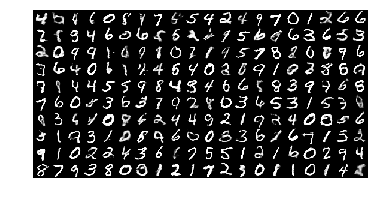

Epoch: [170] time: 3597.70s, d_loss: -5.9019, g_loss: 2.7822
Epoch: [171] time: 3618.12s, d_loss: -5.0149, g_loss: 3.0104
Epoch: [172] time: 3638.84s, d_loss: -6.5360, g_loss: 3.7071
Epoch: [173] time: 3659.74s, d_loss: -7.5745, g_loss: 3.6484
Epoch: [174] time: 3680.62s, d_loss: -0.2923, g_loss: 0.1088
Epoch: [175] time: 3701.20s, d_loss: -3.7863, g_loss: 1.8096
Epoch: [176] time: 3721.91s, d_loss: 7.8996, g_loss: -3.8321
Epoch: [177] time: 3742.90s, d_loss: 2.3343, g_loss: -1.0280
Epoch: [178] time: 3763.44s, d_loss: -0.2322, g_loss: 0.0366
Epoch: [179] time: 3784.53s, d_loss: 5.1203, g_loss: -2.8618


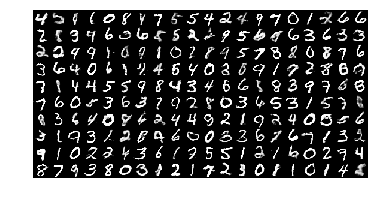

Epoch: [180] time: 3806.55s, d_loss: -2.2950, g_loss: 1.3940
Epoch: [181] time: 3827.35s, d_loss: 4.4571, g_loss: -2.0617
Epoch: [182] time: 3848.07s, d_loss: 5.5628, g_loss: -2.2333
Epoch: [183] time: 3868.75s, d_loss: -1.3398, g_loss: 0.8166
Epoch: [184] time: 3889.61s, d_loss: -8.3735, g_loss: 4.2164
Epoch: [185] time: 3910.75s, d_loss: 8.9579, g_loss: -4.3036
Epoch: [186] time: 3931.79s, d_loss: -4.0619, g_loss: 1.8224
Epoch: [187] time: 3952.71s, d_loss: -6.8081, g_loss: 3.4527
Epoch: [188] time: 3973.78s, d_loss: 5.1892, g_loss: -2.8178
Epoch: [189] time: 3994.51s, d_loss: 4.7547, g_loss: -2.1666


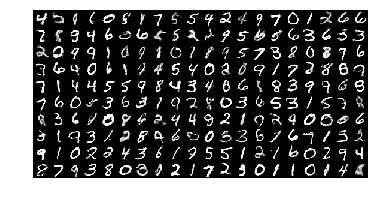

Epoch: [190] time: 4016.68s, d_loss: -0.2116, g_loss: 0.3555
Epoch: [191] time: 4036.97s, d_loss: -6.2679, g_loss: 3.3963
Epoch: [192] time: 4057.48s, d_loss: 7.0673, g_loss: -4.0941
Epoch: [193] time: 4078.36s, d_loss: -6.7141, g_loss: 3.1456
Epoch: [194] time: 4098.69s, d_loss: 8.0136, g_loss: -4.1987
Epoch: [195] time: 4119.75s, d_loss: 7.1099, g_loss: -3.3713
Epoch: [196] time: 4140.43s, d_loss: 4.4710, g_loss: -2.3596
Epoch: [197] time: 4161.24s, d_loss: -3.2644, g_loss: 1.4238
Epoch: [198] time: 4182.15s, d_loss: 1.3072, g_loss: -0.7275
Epoch: [199] time: 4203.00s, d_loss: -2.0846, g_loss: 0.9456


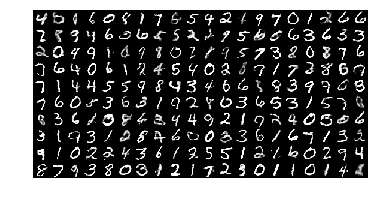

In [3]:
tf.reset_default_graph()

# Specifiy model checkpoint directory & samples directory
checkpoint_dir = 'checkpoint'
samples_dir = 'samples'

sess = tf.Session()
model = WGAN_GP(
    sess,
    input_width=28,
    input_height=28,
    output_width=28,
    output_height=28,
    batch_size=16,
    input_fname_pattern='*.jpg',
    checkpoint_dir=checkpoint_dir,
    samples_dir=samples_dir,
    show_samples=True,
    epoch=200)

# show_all_variables()
init = tf.global_variables_initializer()
sess.run(init)
sample_z = np.random.uniform(-1, 1, size=(200, 100))
samples = model.G.eval(session=model.sess, feed_dict={model.z: sample_z})
plt.imshow(samples[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title('Generated sample')
plt.show()

samples = model.trX[:200]
img = grayscale_grid_vis(samples, nhw=(10, 20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Real MNIST samples')
plt.show()

model.train()

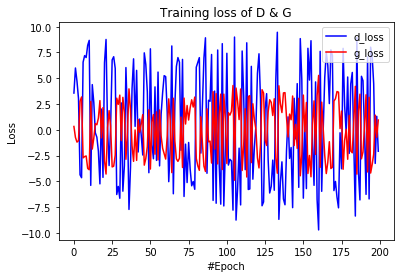

In [4]:
d_loss = model.log['d_loss']
g_loss = model.log['g_loss']
plt.plot(range(len(d_loss)), d_loss, color='blue', label='d_loss')
plt.plot(range(len(g_loss)), g_loss, color='red', label='g_loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.title('Training loss of D & G')
plt.show()

In [6]:
import imageio
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Error while fetching file: ('The read operation timed out',).
Error while fetching file: ('The read operation timed out',).
Try 3. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.049152/45929032 bytes (0.1%204800/45929032 bytes (0.4417792/45929032 bytes (0.9630784/45929032 bytes (1.4843776/45929032 bytes (1.81056768/45929032 bytes (2.3%1269760/45929032 bytes (2.8%1482752/45929032 bytes (3.2%1695744/45929032 bytes (3.7%1908736/45929032 bytes (4.2%2121728/45929032 bytes (4.6%2334720/45929032 bytes (5.1%2400256/45929032 bytes (5.2%2826240/45929032 bytes (6.2%3039232/45929032 bytes (6.6%3252224/45929032 bytes (7.1%3465216/45929032 bytes (7.5%3678208/45929032 bytes (8.0%3743744/45929032 bytes (8.2%4104192/45929032 bytes (8.9%4317184/45929032 bytes (9.4%4530176/45929032 bytes (9.9%4743168/45929032 bytes (10.349561

In [8]:
#imageio.plugins.ffmpeg.download()
imgs = np.array(model.log['gen_samples'])
make_gif(imgs * 255., 'GAN/wgan.gif', true_image=True, duration=2)

from IPython.display import Image
Image(url='GAN/wgan.gif')

UnicodeDecodeError: 'ascii' codec can't decode byte 0xe6 in position 12: ordinal not in range(128)